In [1]:
# packages
import os
import sys
from osgeo import gdal, ogr, osr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

import pydot
from subprocess import check_call
import seaborn as sn
import pickle
import datetime

import warnings
warnings.filterwarnings("ignore")

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [2]:
from pathlib import Path
Path("ml_result").mkdir(parents=True, exist_ok=True)

# UPLOAD IMAGE AND SELECT MODEL

In [3]:
# img_RS = r'../Image/skw_20211207_5b_nF.tif'   #  BROWSE YOUR IMAGE
# training = r'../Dataset/Training_skw_updateCasava/train_11c_noF.shp' #  BROWSE YOUR IMAGE LABEL
# validation = r'../Dataset/Validation_skw_updateCasava/v_skw_11c_noF.shp'  #  BROWSE YOUR IMAGE LABEL


img_RS = r'image_data/skw_20211207_5b_nF.tif'   #  BROWSE YOUR IMAGE
training = r'train_label_data/train_11c_noF.shp' #  BROWSE YOUR IMAGE LABEL
validation = r'val_label_data/v_skw_11c_noF.shp'  #  BROWSE YOUR IMAGE LABEL

# img_RS = r'inpit.tif'   #  BROWSE YOUR IMAGE
# training = r'train.shp' #  BROWSE YOUR IMAGE LABEL
# validation = r'val.shp'  #  BROWSE YOUR IMAGE LABEL

# SELECT ML MODEL

SELECT = 'RF' # 'NN', 'GBT'

if SELECT == 'RF':
    model = RandomForestClassifier(oob_score=True, verbose=True)
elif SELECT == 'NN':
    model = MLPClassifier(max_iter=1000, alpha=0.0001)
elif SELECT == 'GB':
    model = GradientBoostingClassifier(random_state=10)
    
print('YOUR MODE IS:', model)

YOUR MODE IS: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=True, warm_start=False)


Available attributes in the shape file are: ['LU_CODE', 'LU_num']
Image extent: 3396 x 3868 (row x col)
Number of Bands: 5


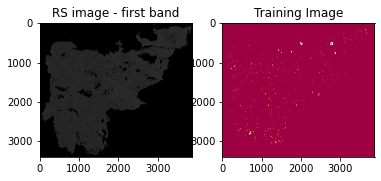

41327 training samples
training data include 11 classes: [ 1  2  3  4  5  6  7  8  9 10 11]
Our X matrix is sized: (41327, 5)
Our y array is sized: (41327,)
Our X_train matrix is sized: (28928, 5)
Our y_train array is sized: (28928,)


In [4]:
# define a number of trees that should be used (default = 500)
est = 200

# how many cores should be used?
# -1 -> all available cores
n_cores = -1
#n_cores = 4


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'LU_num'

# directory, where the classification image should be saved:
classification_image = r'ml_result/ml_class.tif'
# directory, where the all meta results should be saved:
results_txt = r'ml_result/ml_class.txt'

# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

# prepare results text file:

print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))

# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()

# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')
#plt.imshow(img[:, :, 0:4], cmap='viridis')
#plt.title('RS image - composite band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()

# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} training samples'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

# Split training testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))
print('Our X_train matrix is sized: {sz}'.format(sz=X_train.shape))
print('Our y_train array is sized: {sz}'.format(sz=y_train.shape))

# TRAIN MODEL

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.941204935881926
Alternative displaying result
Results on the test set:
              precision    recall  f1-score   support

           1       0.94      0.88      0.91       429
           2       0.92      0.92      0.92       774
           3       0.90      0.98      0.94      1242
           4       0.98      0.99      0.99      1708
           5       0.88      0.86      0.87      1442
           6       0.98      0.95      0.97      1486
           7       0.90      0.82      0.86       553
           8       0.99      0.97      0.98       414
           9       0.99      1.00      0.99      1664
          10       1.00      1.00      1.00      1413
          11       0.84      0.86      0.85      1274

    accuracy                           0.94     12399
   macro avg       0.94      0.93      0.93     12399
weighted avg       0.94      0.94      0.94     12399



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


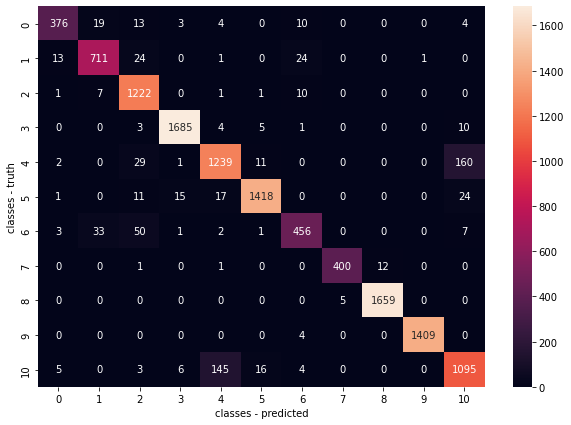

In [5]:
# Test model
X_train = np.nan_to_num(X_train)
#rf = GridSearchCV(rfc, parameter_space, n_jobs=n_cores, cv=5, verbose=10).fit(X_train, y_train)

rf = model.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Best paramete set
#print('Best parameters found:\n', rf.best_params_)

# All results
# means = rf.cv_results_['mean_test_score']
# stds = rf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, rf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# predict result
print('Alternative displaying result')
y_true, y_pred = y_test , rf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_test,rf.predict(X_test))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

In [6]:
# 2. Using pickle
filename = r'ml_result/final_ml_model.pickle'
pickle.dump(rf, open(filename, 'wb'))

# inference load the model from disk
rf = pickle.load(open(filename, 'rb'))
result = rf.score(X_test, y_test)
print(result)

0.941204935881926


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


# SAVE AS SHAPE

In [7]:
import time
start_time = time.time()
#main()

Reshaped from (3396, 3868, 5) to (13135728, 5)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.4min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3396, 3868)


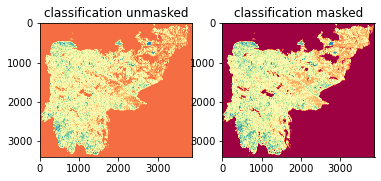

Image saved to: ml_result/ml_class.tif


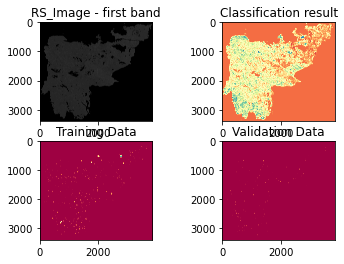

9915 validation pixels
validation data include 11 classes: [ 1  2  3  4  5  6  7  8  9 10 11]
Our X matrix is sized: (9915,)
Our y array is sized: (9915,)
col_0    1    2     3     4     5     6    7    8    9   10    11   All
row_0                                                                  
1      580   16     6     3    19     0    6    0    0    0     0   630
2        8  662    26     0     0     5   37    0    0    0     2   740
3        0    0  1120     0     0     0    5    9    0    0     1  1135
4       22   15    11  1543    16    10   83    0    0    0   146  1846
5       58    1    60    11  1200   106   51    8    0    0   623  2118
6        8    0    46    36   106   947   18    0    0    0   167  1328
7        5    4   141     0     2     0   59   16    3    0     2   232
8        0    0     3     0     1     0    0  370   20    0     1   395
9        0    0     0     0     0     0    0  113  177   17     0   307
10       0    0     0     0     0     0    4    0    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


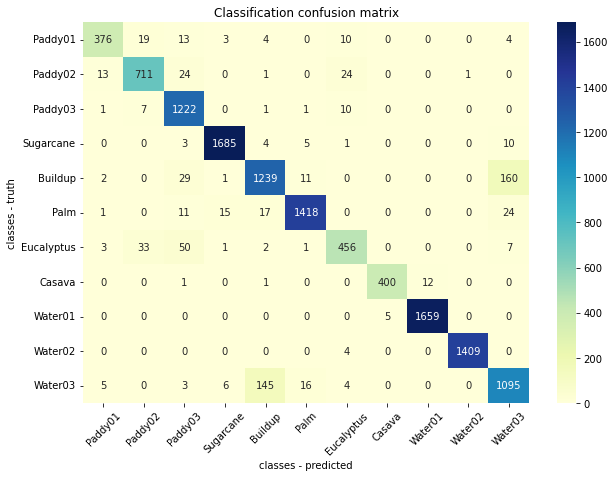

Copy raster done!
Generalization done!
Done!


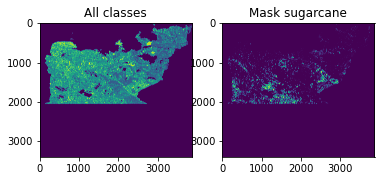

In [8]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)
#img_as_array = img[:, :, :int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    #slices = int(round(len(img_as_array)/2))
    slices = int(round(len(img_as_array)/200))

    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, derzeit: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            #slices = slices/2
            slices = slices/2
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')
    
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))

# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

# mask classification an plot

class_prediction.astype(np.float16)
class_prediction_ = class_prediction*mask

plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(class_prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

cols = img.shape[1]
rows = img.shape[0]

class_prediction_.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(classification_image))

# validation / accuracy assessment

# preparing ttxt file

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# vizualise
plt.subplot(221)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS_Image - first band')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('Classification result')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Spectral)
plt.title('Validation Data')

plt.show()


# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} validation pixels'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Our X matrix is sized: {sz_v}'.format(sz_v=X_v.shape))
print('Our y array is sized: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))
# if you want to save the confusion matrix as a CSV file:
#savename = 'C:\\save\\to\\folder\\conf_matrix_' + str(est) + '.csv'
#convolution_mat.to_csv(savename, sep=';', decimal = '.')

# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

# Plot
x_axis_labels = ['Paddy01','Paddy02', 'Paddy03', 'Sugarcane', 'Buildup', 'Palm', 'Eucalyptus', 'Casava', 'Water01', 'Water02', 'Water03']
y_axis_labels =  ['Paddy01','Paddy02', 'Paddy03', 'Sugarcane', 'Buildup', 'Palm', 'Eucalyptus', 'Casava', 'Water01', 'Water02', 'Water03']


fig = plt.figure(figsize=(10,7))

cm = confusion_matrix(y_test,rf.predict(X_test)) #, normalize='all')
#cm = cm.astype('float')/cm.sum(axis=0)[:,np.newaxis]
#sn.heatmap(cm, annot=True, fmt='g')
sn.heatmap(cm, annot=True, fmt='g',  xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='YlGnBu') #, vmin=0, vmax=1)
plt.title('Classification confusion matrix')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.xticks(rotation=45)
plt.show()

# Open raw classification result
img_ds = gdal.Open(classification_image, 1)  # open image in read-write mode
gt = img_ds.GetGeoTransform()
proj = img_ds.GetProjection()
Band = img_ds.GetRasterBand(1)

# print(gdal.Info(img_ds))
# yRasSize = img_ds.RasterYSize
# xRasSize = img_ds.RasterXSize
# print(yRasSize, xRasSize)

# copy file to other dir and process generalization
fn_new = r"ml_result/rf_class.tif"
driver_tiff = gdal.GetDriverByName("GTiff")
# copy original raster
ds_copy = driver_tiff.CreateCopy(fn_new, img_ds, strict=0)
ds_copy = None
print("Copy raster done!")

# Generalization
ds_class = gdal.Open(r"ml_result/rf_class.tif", 1)
Band = ds_class.GetRasterBand(1)
gdal.SieveFilter(srcBand=Band, maskBand=None, dstBand=Band, threshold=1, connectedness=1, callback=gdal.TermProgress_nocb)
ds_class = None
Band = None
print("Generalization done!")

# mask only sugarcane
ds_gen = gdal.Open(r"ml_result/rf_class.tif", 1)
ds_mask = r"ml_result/rfgen_cane.tif"
gt = ds_gen.GetGeoTransform()
proj = ds_gen.GetProjection()

Band = ds_gen.GetRasterBand(1)
array = Band.ReadAsArray()
plt.subplot(121)
# plt.figure()
plt.imshow(array)
plt.title("All classes")

# Making mask using sugarcane class = 1
sel = 4
binmask = np.where((array == sel),1,0)
# plt.figure()
# plt.imshow(binmask)

# Masking generalized classification using binmask
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create(ds_mask, xsize = binmask.shape[1],
                      ysize = binmask.shape[0], bands = 1, 
                      eType = gdal.GDT_Int16)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(binmask)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

# close your datasets and bands!!!
outband = None
outds = None

# display mask result
caneImg = gdal.Open(r"ml_result/rfgen_cane.tif")
Band = caneImg.GetRasterBand(1)
array = Band.ReadAsArray()
#plt.figure()
plt.subplot(122)
plt.imshow(array)
plt.title("Mask sugarcane")


shp_ds = r"ml_result/rf_sugarcane.shp"
src_ds = gdal.Open(r"ml_result/rfgen_cane.tif",1)
srcband = src_ds.GetRasterBand(1)
dst_layerName = "sugarcane"
drv = ogr.GetDriverByName("ESRI Shapefile")

if os.path.exists(shp_ds):
    drv.DeleteDataSource(shp_ds)

dst_ds = drv.CreateDataSource(shp_ds)

sp_ref = osr.SpatialReference()
sp_ref.SetFromUserInput("EPSG:32648")

dst_layer = dst_ds.CreateLayer(dst_layerName, srs=sp_ref)

fld = ogr.FieldDefn("VALUE", ogr.OFTInteger)
dst_layer.CreateField(fld)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex("VALUE")

gdal.Polygonize(srcband, None, dst_layer, 0, [], callback=None)
dst_ds.Destroy()
print('Done!')

In [9]:
print()
print(f'Final Time Execution --- %s Seconds ---' % (time.time() - start_time))
print()
import datetime
SecToConvert =  time.time() - start_time #56000
ConvertedSec = str(datetime.timedelta(seconds = SecToConvert))
print("Converted Results are: ", ConvertedSec)
print()


Final Time Execution --- 228.3916871547699 Seconds ---

Converted Results are:  0:03:48.391877

